In [1]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

# Decomposing signals in components (Maxtrix factorization)

To reduce the dimensionality and still keep statstical signals and patterns from our dataset matrix $X$, which is 
$[n_{samples}, n_{dimensions}]$.

We often can use *matrix factorixation* methods to decompose $X$ into various forms, each of which has various mathematical properties.

One of the most common factorizations that applies well here, is Singular value decomposition (SVD) which generalizes the eigendecomposition of a square normal matrix to any $m\times n$ matrix via an extension of the polar decomposition.

$$ X = M = U\Sigma V^* $$

Where $U$ is an $m \times m$ real unitary matrix, $\Sigma$ is an $m \times n$ rectangular diagonal matrix with non-negative real numbers on the diagonal, and $V$ is an $n \times n$ real unitary matrix. $U$ and $V=V^*$ are real orthonormal matrices.

The diagonal entries $\sigma_i=\Sigma_{i i}$ of $\Sigma$ are known as the *singular value's* of $X$. The number of non-zero singular values is equal to the rank of $X$. The columns of $U$ and the columns of $V$ are called the *left-singular vectors* and *right-singular vectors* of $X$, respectively. The SVD is not unique. It is always possible to choose the decomposition so that the singular values $\Sigma_{i i}$are in descending order.

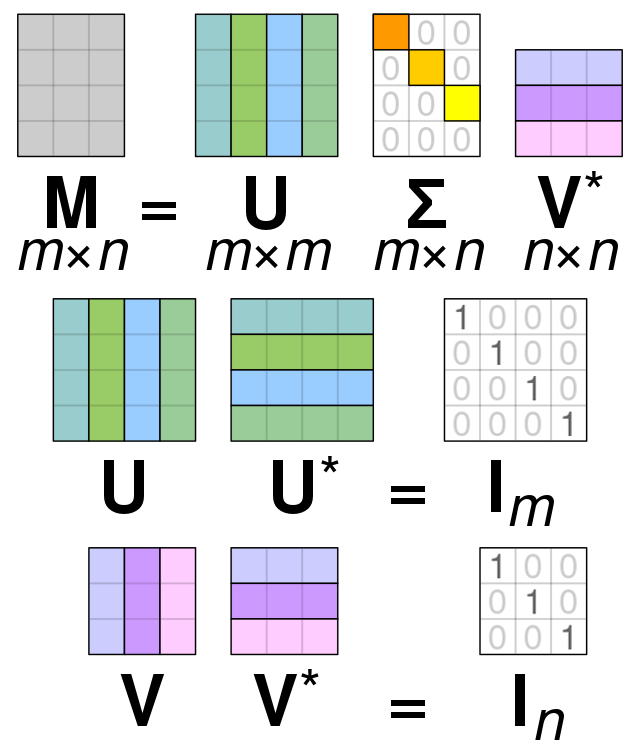

We can use this form to reduce the dimensionality of $X$, by setting the $s$ smallest *singular value's* to $0$, thus we can eliminate the corresponding $s$ columns of $U$ and $V$. This would then form a new $X'$ that has the dimensions of $[n_{samples}, n_{dimensions - s}]$. This is what the model `TruncatedSVD` tries to do.

## Principal Component Analysis

Principal component analysis (PCA) uses this orthogonal transformation to convert a set of observations of possibly correlated variables $X$ into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first principal component has the largest possible variance (that accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors (each being a linear combination of the variables and containing $n$ observations) are an uncorrelated orthogonal basis set. PCA is sensitive to the relative scaling of the original variables.

This centers each sample in $X$ to have a mean of $0$, then applies the SVD decomposition. This results in a very useful property that the variance of the data in any low-dimensional representation is maximized. The eigenvectors or *right-singular vectors* that correspond to the largest eigenvalues or *singular value's* (the principal components) can now be used to reconstruct a large fraction of the variance of the original data.

We use this `sklearn` to reduce the dimension of the $X$ in such a way that the variance of the data in the low-dimensional representation is maximized. Which can be useful for plotting, via reducing the $X$ to $2d$ or $3d$.


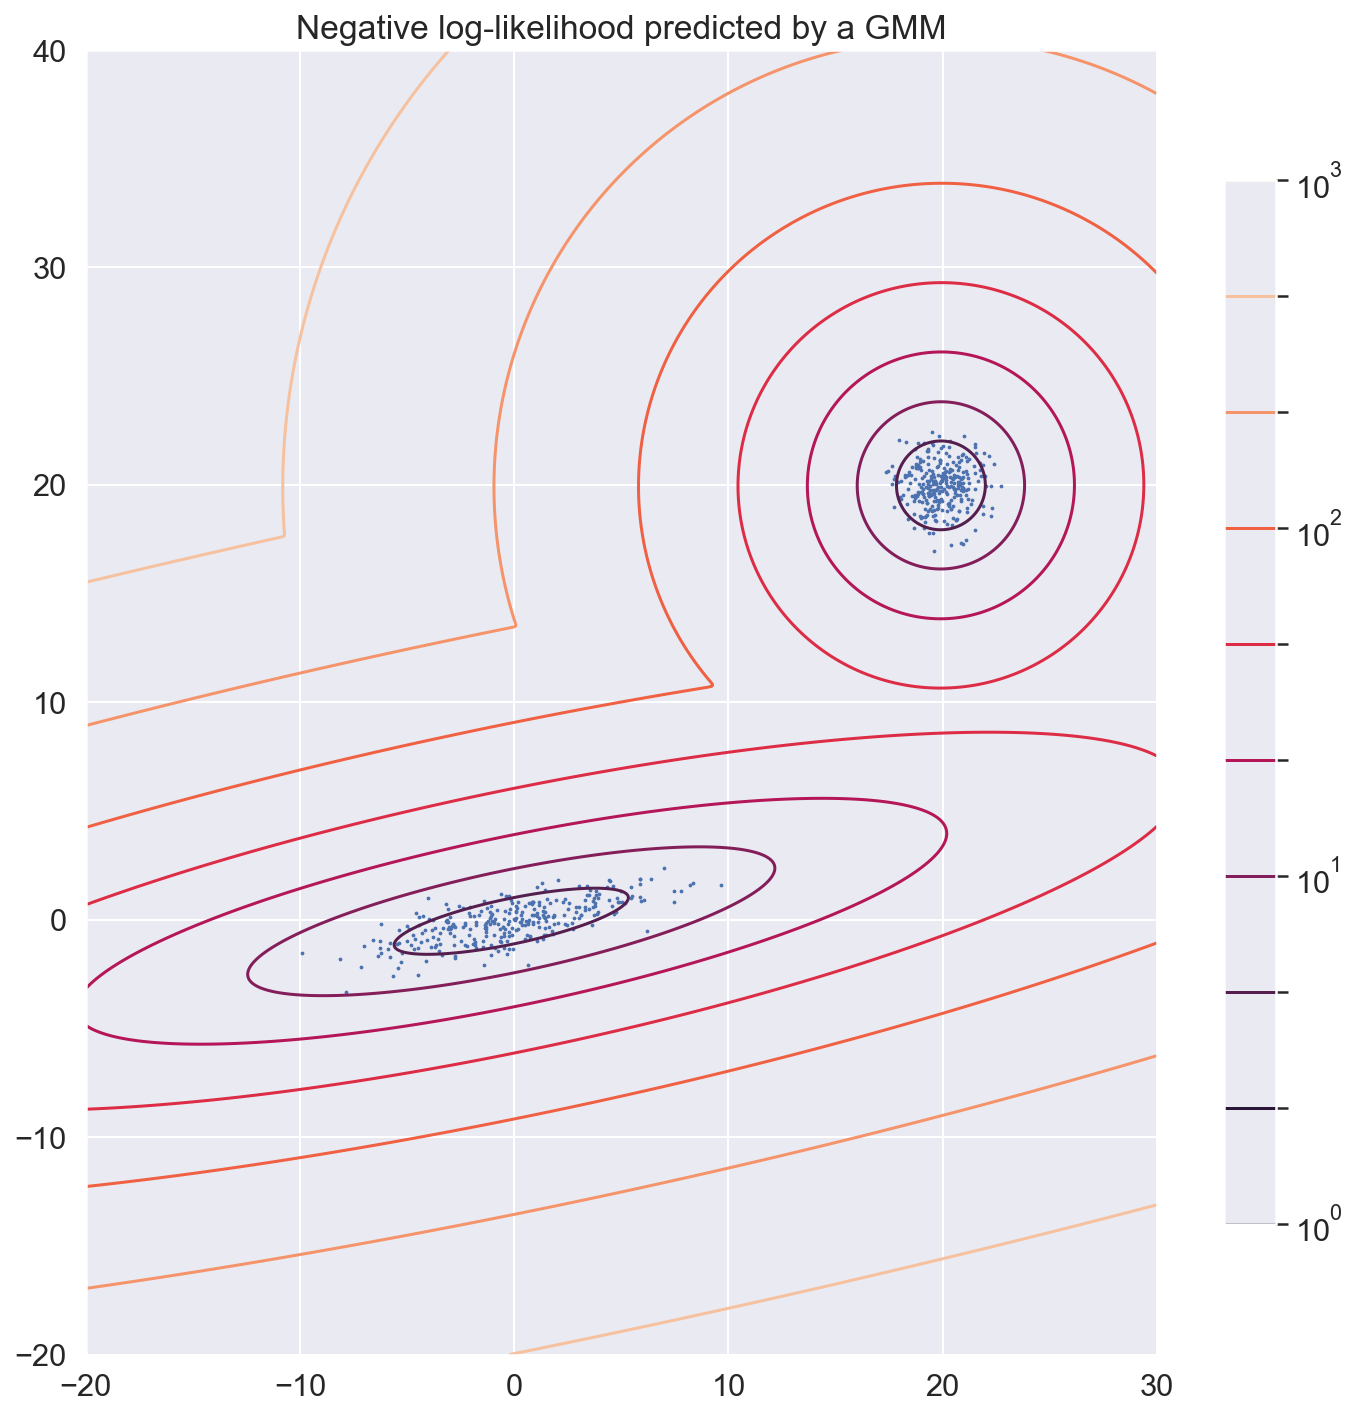

In [2]:
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 300

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.,1000)
y = np.linspace(-20., 40.,1000)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

plt.figure(figsize=(12, 12))
CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

Fitting model on a small sub-sample of the data
done in 0.305s.
Predicting color indices on the full image (k-means)
done in 0.201s.
Predicting color indices on the full image (random)
done in 0.143s.


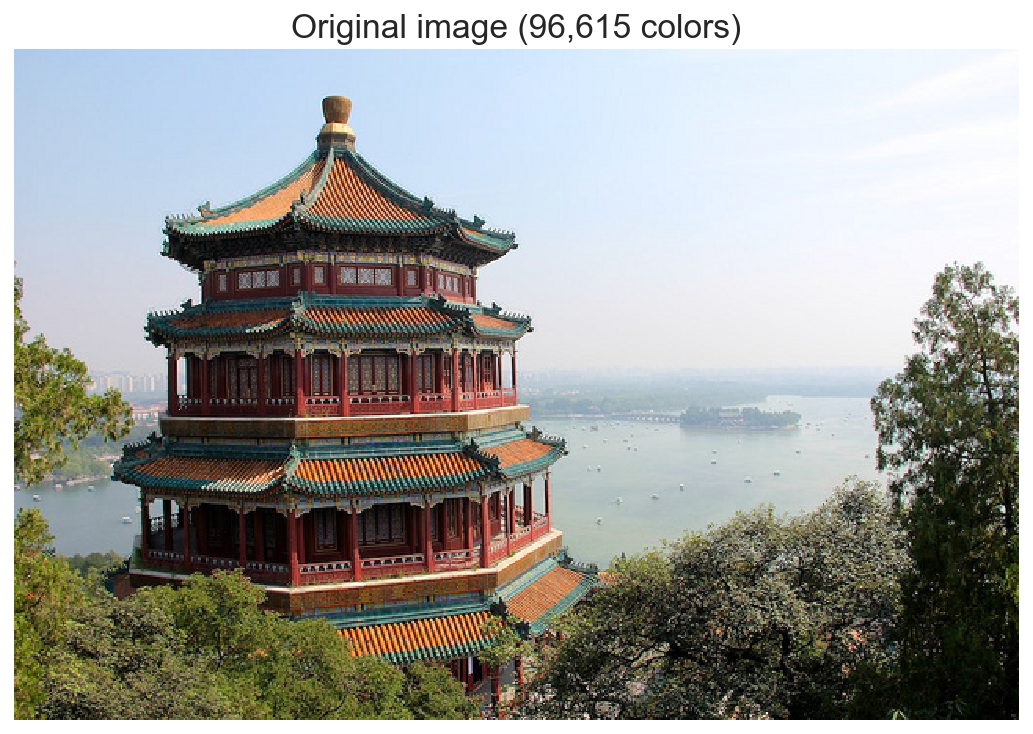

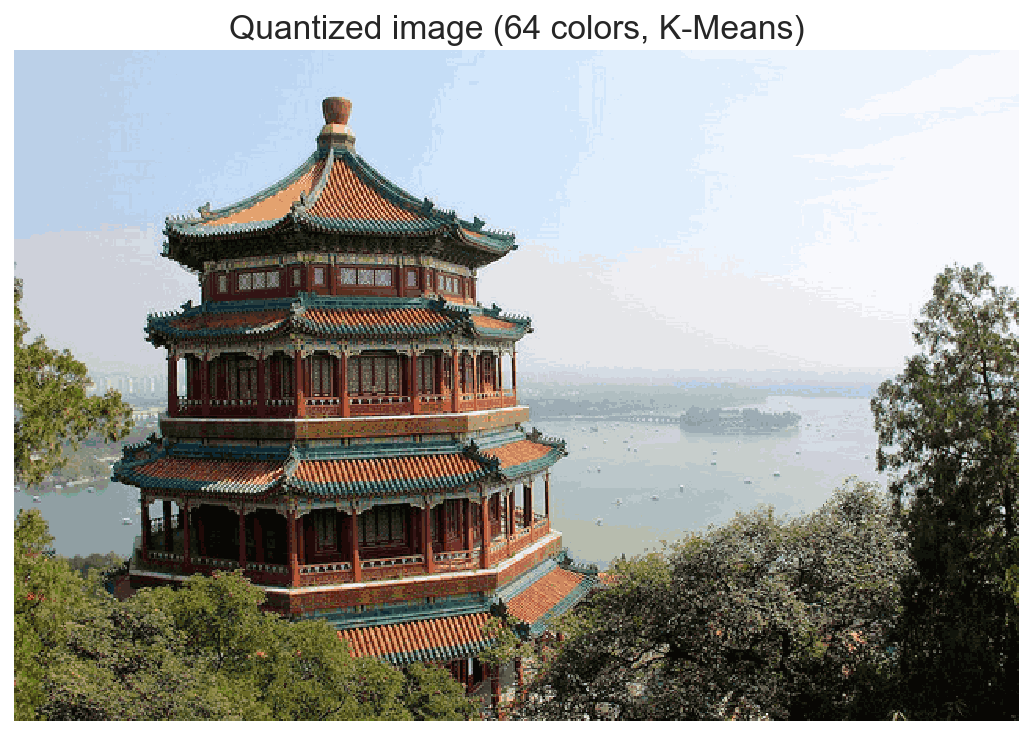

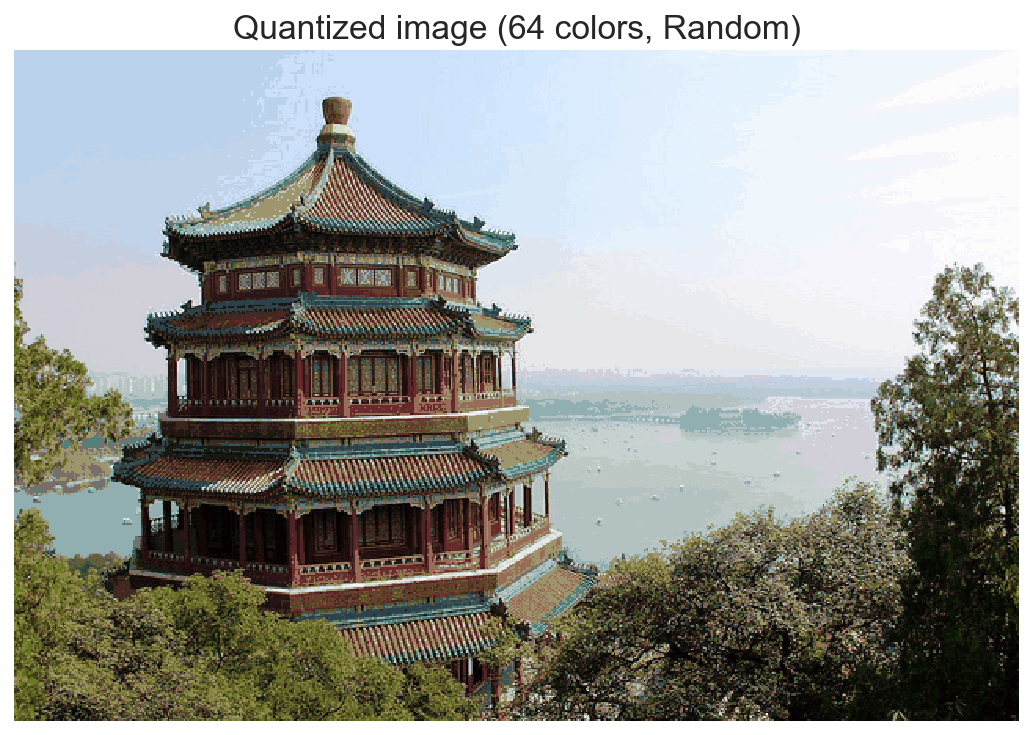

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 64

# Load the Summer Palace photo
china = load_sample_image("china.jpg")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
china = np.array(china, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print("done in %0.3fs." % (time() - t0))

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print("done in %0.3fs." % (time() - t0))


codebook_random = shuffle(image_array, random_state=0)[:n_colors]
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random,
                                          image_array,
                                          axis=0)
print("done in %0.3fs." % (time() - t0))


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(china)

plt.figure(2)
plt.clf()
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.figure(3)
plt.clf()
plt.axis('off')
plt.title('Quantized image (64 colors, Random)')
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()

In [3]:






---

Drop data

Illustrate with an image, kmeans dataset one

SyntaxError: invalid syntax (<ipython-input-3-7b271289cae2>, line 1)